<a href="https://colab.research.google.com/github/Wojak27/TDDE01Labs/blob/master/Convoluted_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [0]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


# How will we create noise in the picture?
This is pretty simple, we will sprinkle them with some salt and peppar!

2


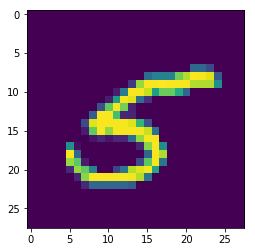

In [0]:
# check noisinig function
# print(np.ndim(image))
img = mnist.train.next_batch(1)[0]
print(np.ndim(img))
plt.imshow(np.reshape(img, (28,28)))

In [0]:
# the noising function 
def get_noisy_image(img):
    mean = 0.0   # some constant
    std = 0.3    # some constant (standard deviation)
    noisy_img = img - np.random.normal(mean, std, img.shape)
    noisy_img_clipped = np.clip(noisy_img, 0, 255)  # we might get out of bounds due to noise
    return noisy_img_clipped

In [0]:
# the noising function helper
def noise_images(images):
    arr = []
    for image in images:
        arr.append(get_noisy_image(image))
    return arr

1
1


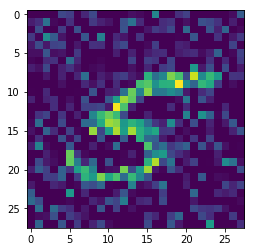

In [0]:
plt.imshow(np.reshape(get_noisy_image(img), (28,28)))
x = mnist.train.next_batch(1)[0]
print(len(x))
x_noisy = noise_images(x)
print(len(x_noisy))

## Create the convolution part

In [0]:
tf.reset_default_graph() # in case there are any other notebooks running

In [0]:
batch_size = 100

In [0]:
# Helper
#tf.executing_eagerly()
# Init weights
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape,stddev=0.1)
    return tf.Variable(init_random_dist)

In [0]:
#Init bias
def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

In [0]:
#Conv2d
def conv2d(x,W):
    # x --> [batch, Height, Width, Channels]
    # W --> [filter Height, filter Width, Channels In, Channels Out]
    # this is a kind of a wrapper around the standard tensorflow function
    return tf.nn.conv2d(x,W,strides=[1,1,1,1], padding = "SAME") #padding, one is valid and one is same

In [0]:

# Pooling
def max_pool_2by2(x):
    #x -->[batch, H, W, c]
    # ksize is the size of the window for the each dimension of the input tensor
    # stride is the stride of the sliding widow for each dimension of the input tensor2
    return tf.nn.max_pool(x,ksize=[1,2,2,1],strides=[1,2,2,1],padding="SAME")


In [0]:
# CONVOLUTIONAL LAYER
def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(tf.add(conv2d(input_x,W),b)) 

In [0]:
# Normal layer (fully connected)
def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size,size])
    b = init_bias([size])
    return tf.matmul(input_layer,W)+b

In [0]:
# Deconvolutional layer upskales the image so that he output will be 
# batch_size = batch_size
# output_width = input_width*2,
# output_height = input_height*2 
# channels = input_channels/2 

def deconv2d(input, out_shape, name="deconv2d"):
    strides=[1, 4, 4, 1]
    input_shape = input.get_shape().as_list()
    with tf.variable_scope(name) as scope:
        W1_1 = tf.get_variable("w", [5,5, out_shape[-1], input_shape[-1]],
                            initializer=tf.random_normal_initializer(stddev=0.02))
        
        dyn_input_shape = tf.shape(input)
        batch_size = dyn_input_shape[0]

        output_shape = tf.stack([batch_size, out_shape[1], out_shape[2], out_shape[3]])
    
        output = tf.nn.conv2d_transpose(input, W1_1, output_shape, strides, padding="SAME")

        return output

In [0]:
# Paceholder
x = tf.placeholder(tf.float32, shape=[None,784])

In [0]:
# Layers
x_image = tf.reshape(x,[-1,28,28,1])
x.get_shape()

TensorShape([Dimension(None), Dimension(784)])

In [0]:
# first convolution with 5x5 filter and pooling. Feature image size: 14x14
# num of features 32
convo_1 = convolutional_layer(x_image,shape=[5,5,1,32])
convo_1_pooling = max_pool_2by2(convo_1)
convo_1_pooling.get_shape()

TensorShape([Dimension(None), Dimension(14), Dimension(14), Dimension(32)])

In [0]:
# second convolution and pooling. Feature image size: 7x7
# num of features 64
convo_2 = convolutional_layer(convo_1_pooling, shape=[5,5,32,64])
convo_2_pooling = max_pool_2by2(convo_2)
convo_2_pooling.get_shape()

TensorShape([Dimension(None), Dimension(7), Dimension(7), Dimension(64)])

In [0]:
# upsampling. Feature image size: 14x14
# num of features 32
convo_3_upsampling = deconv2d(convo_2_pooling, [batch_size,14,14,32], "convo_3_upsampling")
convo_3_upsampling.get_shape()

TensorShape([Dimension(None), Dimension(14), Dimension(14), Dimension(32)])

In [0]:
# upsampling. Feature image size: 28x28
# num of features 1
convo_4_upsampling = deconv2d(convo_2_pooling, [batch_size,28,28,1], "convo_4_upsampling")
convo_4_upsampling.get_shape() # debug

TensorShape([Dimension(None), Dimension(28), Dimension(28), Dimension(1)])

In [0]:
output_flattened = tf.reshape(convo_4_upsampling, [-1,28*28*1])
output_flattened.get_shape() # debug

TensorShape([Dimension(None), Dimension(784)])

In [0]:
learning_rate = 0.001
# loss function
loss = tf.reduce_mean(tf.square(output_flattened-x))
# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)

# train
train = optimizer.minimize(loss)

In [0]:
init = tf.global_variables_initializer()

In [0]:
saver = tf.train.Saver()

In [0]:
num_epochs = 500

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(num_epochs):
        num_batches = mnist.train.num_examples // batch_size
        
        for iteration in range(num_batches):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            #sess.run(train, feed_dict = {x:X_batch}) #training on clean data
            X_noisy_batch = noise_images(X_batch) # training on noisy data
            sess.run(train, feed_dict = {x:X_noisy_batch}) # training on noisy data
        training_loss = loss.eval(feed_dict={x:X_batch})
        
        print("EPOCH: {} LOSS: {}".format(epoch, training_loss))
        
    saver.save(sess, "./example_stacked_autoencoder.ckpt")

EPOCH: 0 LOSS: 0.008937790989875793
EPOCH: 1 LOSS: 0.0072655812837183475
EPOCH: 2 LOSS: 0.006556784268468618
EPOCH: 3 LOSS: 0.006326588802039623
EPOCH: 4 LOSS: 0.006436093710362911
EPOCH: 5 LOSS: 0.005854962393641472
EPOCH: 6 LOSS: 0.0056239585392177105
EPOCH: 7 LOSS: 0.005485684145241976
EPOCH: 8 LOSS: 0.005545277614146471
EPOCH: 9 LOSS: 0.005837689619511366
EPOCH: 10 LOSS: 0.005632662680000067
EPOCH: 11 LOSS: 0.005530489142984152
EPOCH: 12 LOSS: 0.005874225404113531
EPOCH: 13 LOSS: 0.005776121746748686
EPOCH: 14 LOSS: 0.005845682695508003
EPOCH: 15 LOSS: 0.005717509426176548
EPOCH: 16 LOSS: 0.005878840107470751
EPOCH: 17 LOSS: 0.006091566290706396
EPOCH: 18 LOSS: 0.006501997355371714
EPOCH: 19 LOSS: 0.006261600647121668
EPOCH: 20 LOSS: 0.00647748215124011
EPOCH: 21 LOSS: 0.006491239182651043
EPOCH: 22 LOSS: 0.006233145482838154
EPOCH: 23 LOSS: 0.005912859924137592
EPOCH: 24 LOSS: 0.00622165109962225
EPOCH: 25 LOSS: 0.006223259028047323
EPOCH: 26 LOSS: 0.006439943797886372
EPOCH: 27 L

In [0]:
num_test_images = 16
test_images = noise_images(mnist.test.images[:num_test_images])
#test_images = mnist.test.images[:num_test_images]

with tf.Session() as sess:
    saver.restore(sess, "./example_stacked_autoencoder.ckpt")
    results = output_flattened.eval(feed_dict={x:test_images})

INFO:tensorflow:Restoring parameters from ./example_stacked_autoencoder.ckpt


16


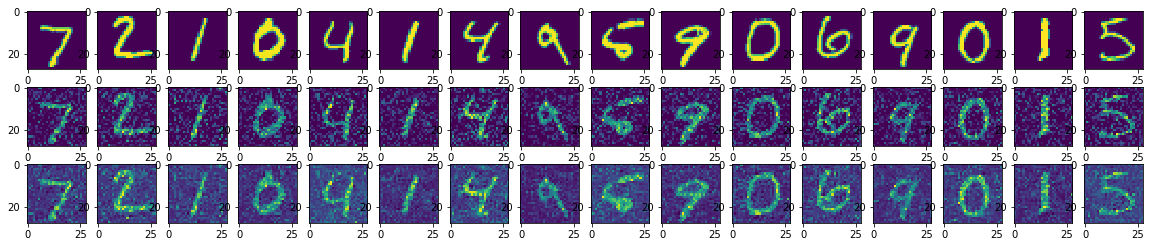

In [0]:
# Compare original images with their reconstructions
f, a = plt.subplots(3,16, figsize=(20,4))
print(len(results))
for i in range(num_test_images):
    a[0][i].imshow(np.reshape(mnist.test.images[i], (28,28))) # Original
    a[1][i].imshow(np.reshape(test_images[i], (28,28))) # noised
    a[2][i].imshow(np.reshape(results[i], (28,28))) # output

The surrounding area around the digit is quite a bit brighter than on the original image. The model has been overfitted and clearly have run for more epochs than needed. We can make it better!

# Try to get better performance using what exactly?


In [0]:
def run_network(num_epochs = 200):
  # init session 
  with tf.Session() as sess:
      sess.run(init)
      #run for epochs: num_epochs
      for epoch in range(num_epochs):
          num_batches = mnist.train.num_examples # batch_size
          
          #run for number of iterations
          for iteration in range(num_batches):
              # get the next batch form the build in tensorflow datasets
              X_batch, y_batch = mnist.train.next_batch(batch_size)
              #sess.run(train, feed_dict = {x:X_batch}) #training on clean data
              X_noisy_batch = noise_images(X_batch) # training on noisy data
              sess.run(train, feed_dict = {x:X_noisy_batch}) # training on noisy data
              
          # compare with the original (or not) images    
          training_loss = loss.eval(feed_dict={x:X_batch})

          print("EPOCH: {} LOSS: {}".format(epoch, training_loss))

      saver.save(sess, "./example_stacked_autoencoder.ckpt")

In [36]:
# For better debugging
# tf.tf.enable_eager_execution()

tf.reset_default_graph() # clear the graph from variables

# And this is where we actually create the new Conv neural network!
# Paceholder

# Layers
x_image = tf.reshape(x,[-1,28,28,1])
x.get_shape()
# CREATING LAYERS

# first convolution with 5x5 filter and pooling. Feature image size: 14x14
# num of features 32
n = convolutional_layer(x_image,shape=[5,5,1,32])
n = max_pool_2by2(n)
n.get_shape()

# second convolution and pooling. Feature image size: 7x7
# num of features 64
n = convolutional_layer(n, shape=[5,5,32,64])
n = max_pool_2by2(n)
n.get_shape()

# upsampling. Feature image size: 14x14
# num of features 32
n = deconv2d(n, [batch_size,14,14,32], "deconv2d_layer1")
n.get_shape()

# upsampling. Feature image size: 28x28
# num of features 1
n = deconv2d(n, [batch_size,28,28,1], "deconv2d_layer2")
n.get_shape() # debug

output_flattened = tf.reshape(n, [-1,28*28*1])
output_flattened.get_shape() # debug

# Setting some learning rate
learning_rate = 0.001

# loss function
loss = tf.reduce_mean(tf.square(output_flattened-x))
# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)

# Train, or in other words
# use the optimizer to minimize the loss function
train = optimizer.minimize(loss)

init = tf.global_variables_initializer()

# init the saver for the model
saver = tf.train.Saver()

run_network()

ValueError: ignored